# Data Visualization

In this tutorial we will look on visualizing data. Although numbers can tell us a satisfying story, a visual of our data will allow us to easily identify trends (and will look amazing on a presentation *hint* *hint*).
 
 ## A few ground rules

 - Remember to run every cell.
     - Parts of this workshop won't work if this condition isn't met.
 - Please don't change my asserts.
     - If you're receiving an incorrect answer please don't change the assert answer just to get it right. You            won't learn anything and will probably fail the rest of the tutorial. Feel free to message slack on the #workshops channel if you get stuck.
     

In [1]:
%matplotlib inline
#Don't mind this. I'm just trying to double check you work :)
def assertAns(condition, fail_str, suc_str):
    assert condition, fail_str
    print(suc_str)

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

We wiil be using GeoPandas here.

GeoPandas is a project to add support for geographic data to pandas objects. It currently implements GeoSeries and GeoDataFrame types which are subclasses of pandas.Series and pandas.DataFrame respectively. GeoPandas objects can act on shapely geometry objects and perform geometric operations.

GeoPandas geometry operations are cartesian. The coordinate reference system (crs) can be stored as an attribute on an object, and is automatically set when loading from a file. Objects may be transformed to new coordinate systems with the to_crs() method. There is currently no enforcement of like coordinates for operations, but that may change in the future.

If you like to know more, here is the source
https://github.com/geopandas/geopandas


Lets start by importing the data frame

https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e4ec3384-056f-aa59-70f7-9ad7706f31a3

Click on this link, scroll down to the bottom, and click on "Toronto Centreline (Toronto Centreline (WGS84 - Latitude / Longitude)) to download the shapefile.

https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#5db8d9e0-1ef4-8bc9-5932-edf87a551163

Then download the csv version of Traffic Camera data (Traffic Camera List (CSV)).


In [3]:
toronto= gpd.read_file("../datasets/centreline_wgs84/CENTRELINE_WGS84.shp")

Visualizing a Data Set is easy by using plot()

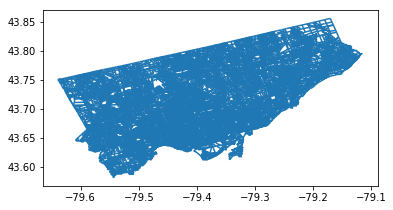

In [4]:
toronto.plot()

Looks kind of scratchy right, let`s make it looks pretty

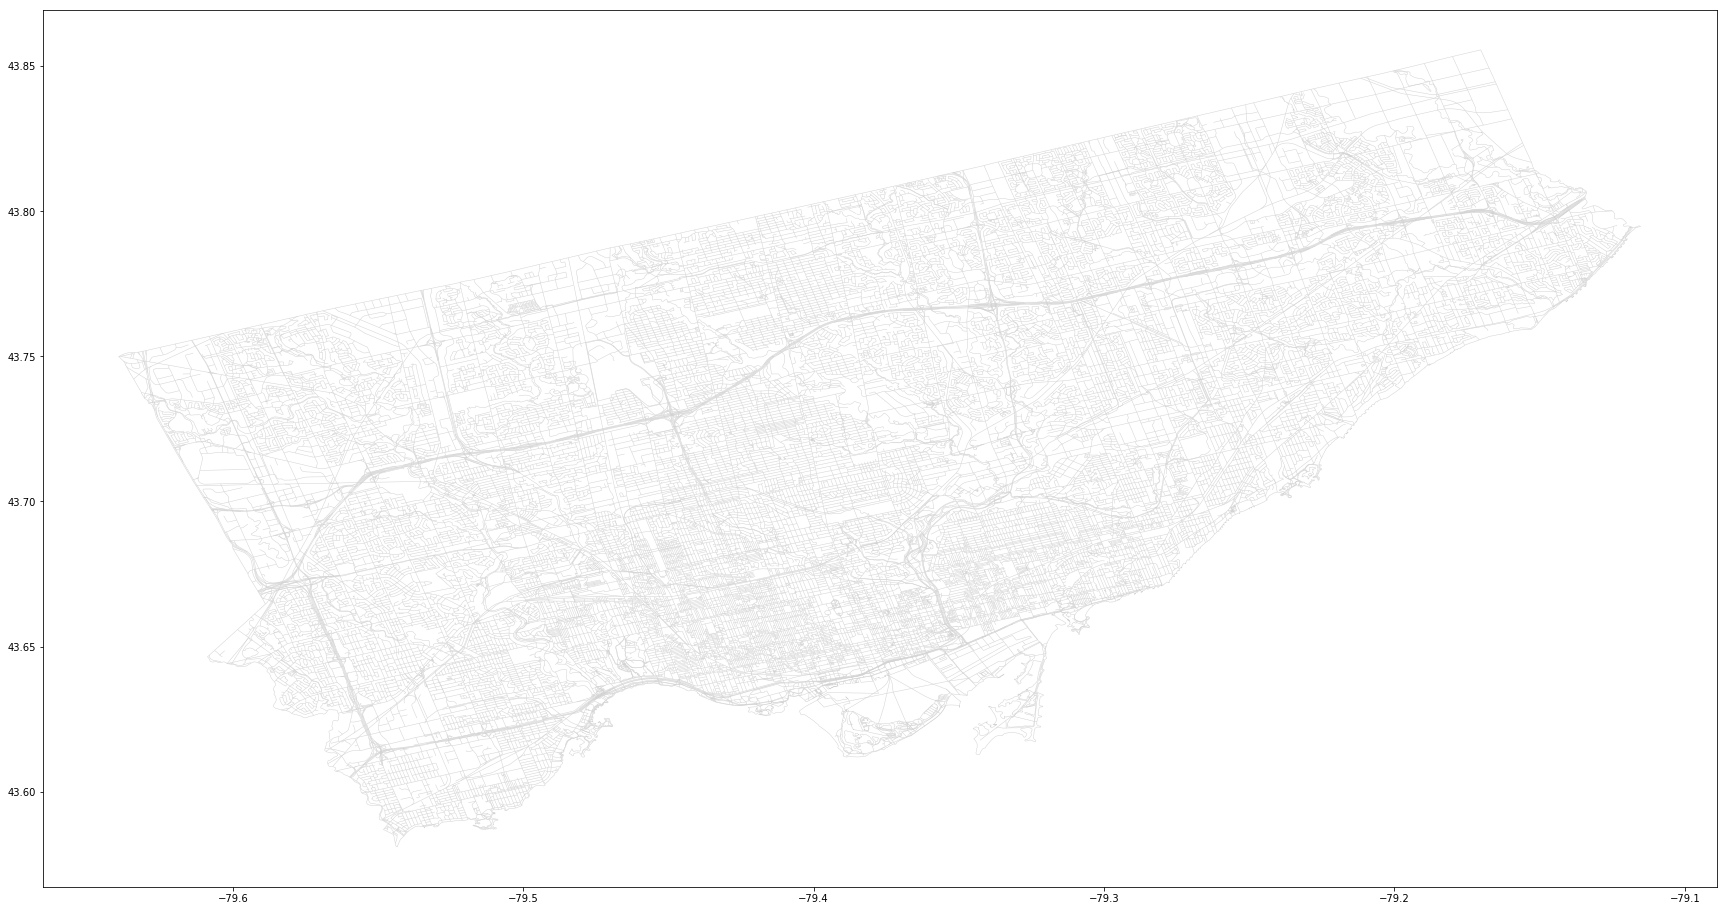

In [5]:
toronto.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(30,20))

you can adjust the size, color of the map by changing the parameters of the plot function

# Changing the CRS (Coordinate Reference System)


When dealing with maps, we have to make sure every layer have the same coordinate reference. So let me show you how to change the CRS. (Hint: if your data frames do not match propertly, you might want to go back here)

### Way one :Just changing the Projection

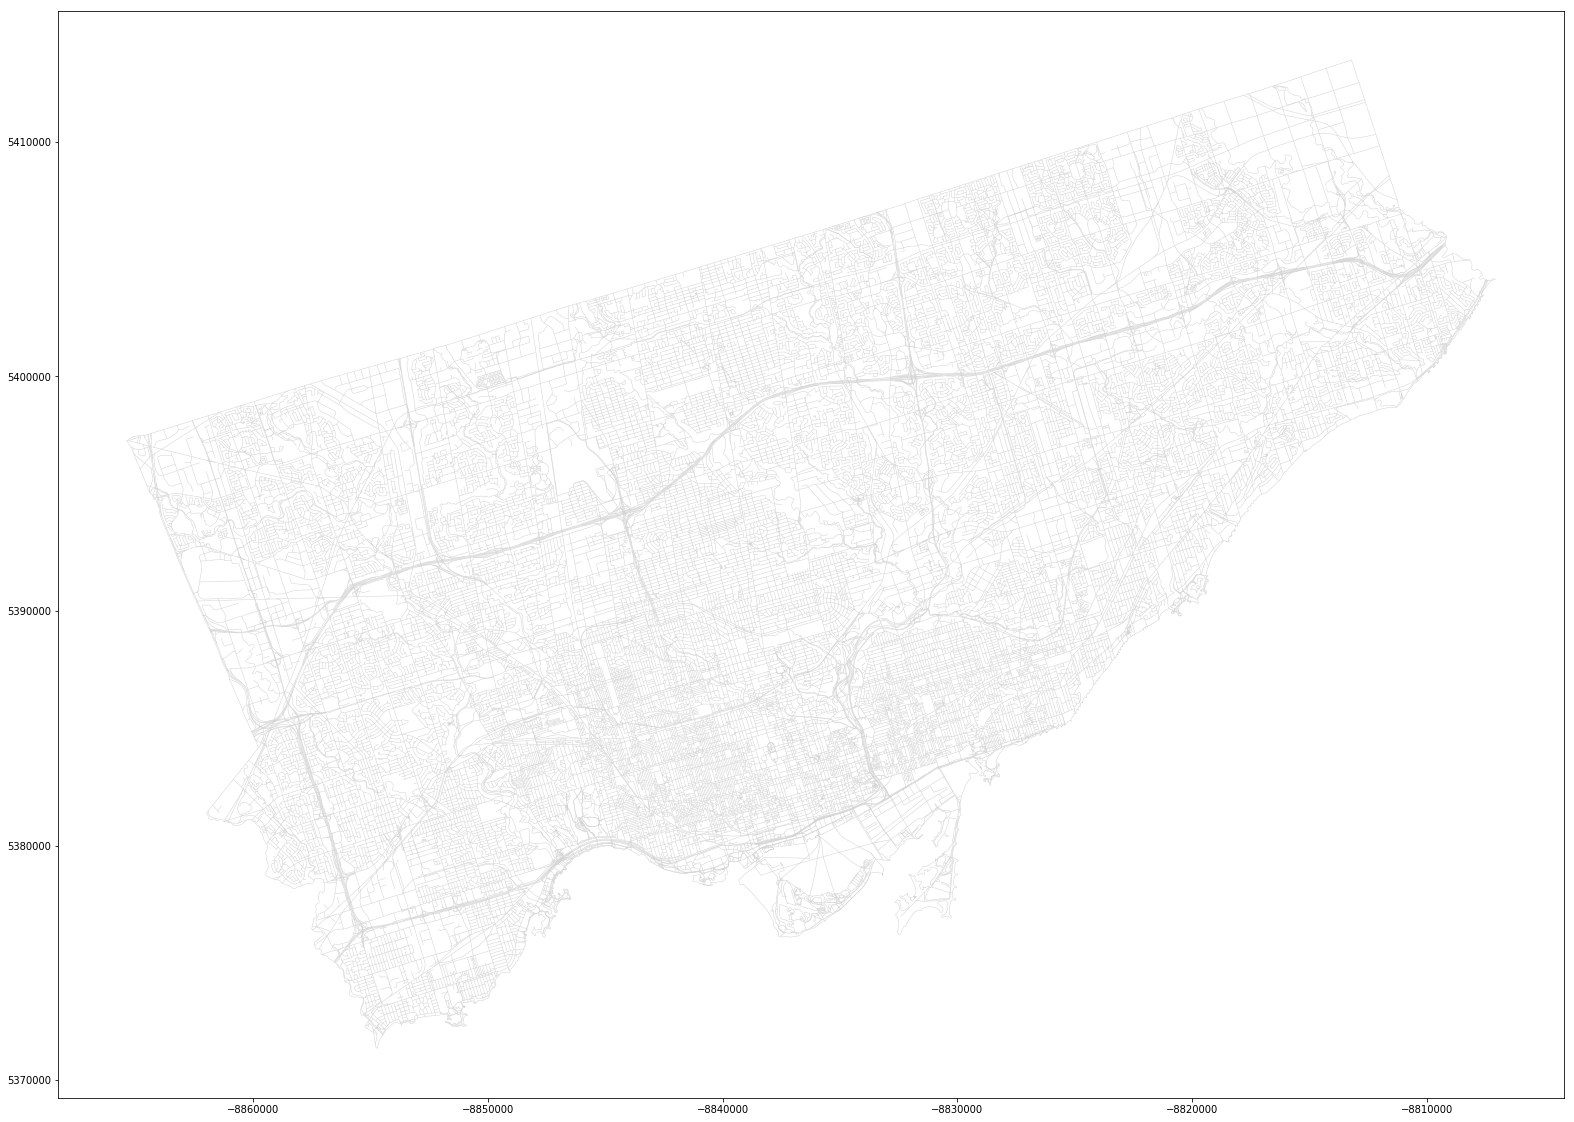

In [6]:
# Go into the crs to convert it...
# ignore the datum and spheroid,
# just change the PROJECTION to MERCATOR
toronto.to_crs({'proj': 'merc'}).plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(30,20))

### Way one : secret code

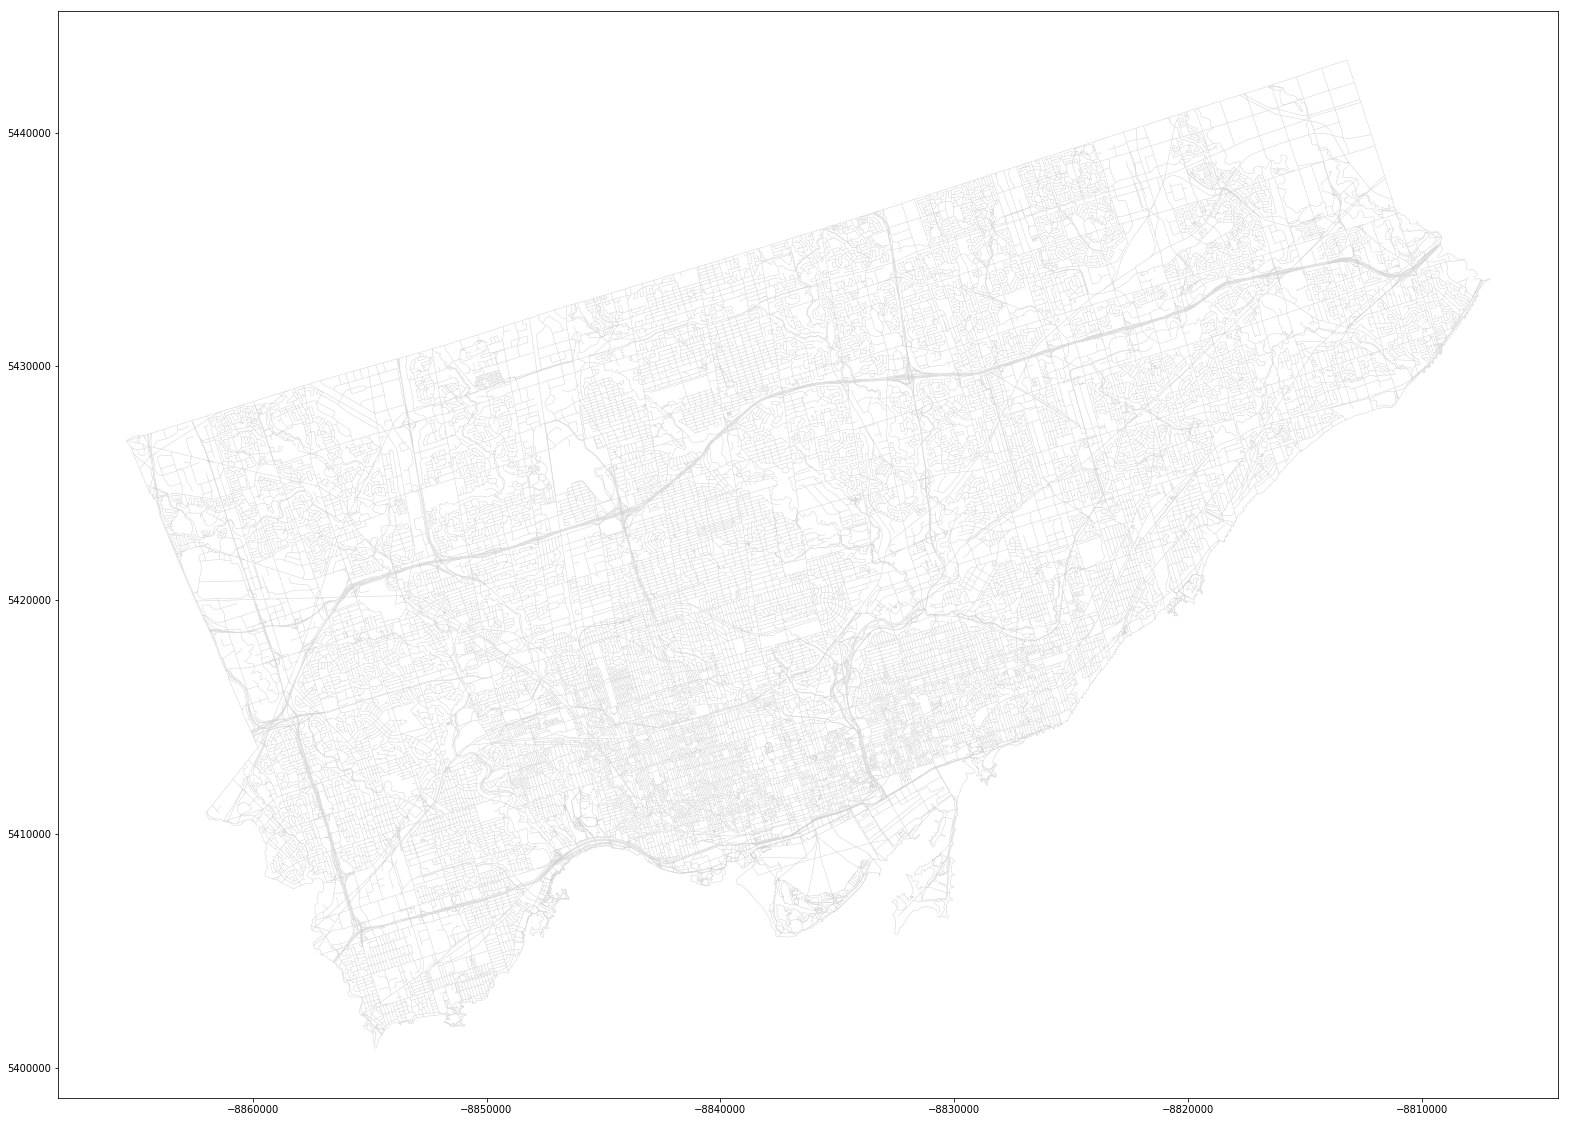

In [7]:
# Give it the SECRET CODE from the PETROLEUM GROUP
# (which you can try to find by googling)
# (or hopefully you have a list because they're
# all very confusingly/similarly named)
toronto.to_crs(epsg=3857).plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(30,20))

## Adding Data on a Map

Let start by analyzing the traffic light in toronoto

In [8]:
df = pd.read_csv("../datasets/tmcearthcameras.csv")

In [9]:
def make_point(row):
    return Point(row.Longitude, row.Latitude)

In [10]:
points = df.apply(make_point, axis=1)

# Make a new GeoDataFrame
# using the data from our old df
# but also adding in the geometry we just made
trafficlights = gpd.GeoDataFrame(df, geometry=points)

# It doesn't come with a CRS because it's a CSV, so let's
# say "hey, let's use the standard shape of the earth etc"
trafficlights.crs = {'init': 'epsg:4326'}

# Let's look at the first few
trafficlights.head(1)

Camera Number   Latitude  Longitude Main Road  Cross Street     Group  \
0    Camera8001  43.643023 -79.381606   YORK ST  BREMNER BLVD  Arterial   

                                      Traffic Image   \
0   http://opendata.toronto.ca/transportation/tmc...   

                       North Reference Static Image   \
0   http://opendata.toronto.ca/transportation/tmc...   

                       South Reference Static Image   \
0   http://opendata.toronto.ca/transportation/tmc...   

                        East Reference Static Image   \
0   http://opendata.toronto.ca/transportation/tmc...   

                         West Reference Static Image  \
0   http://opendata.toronto.ca/transportation/tmc...   

                       geometry  
0  POINT (-79.381606 43.643023)

Let`s plot those point

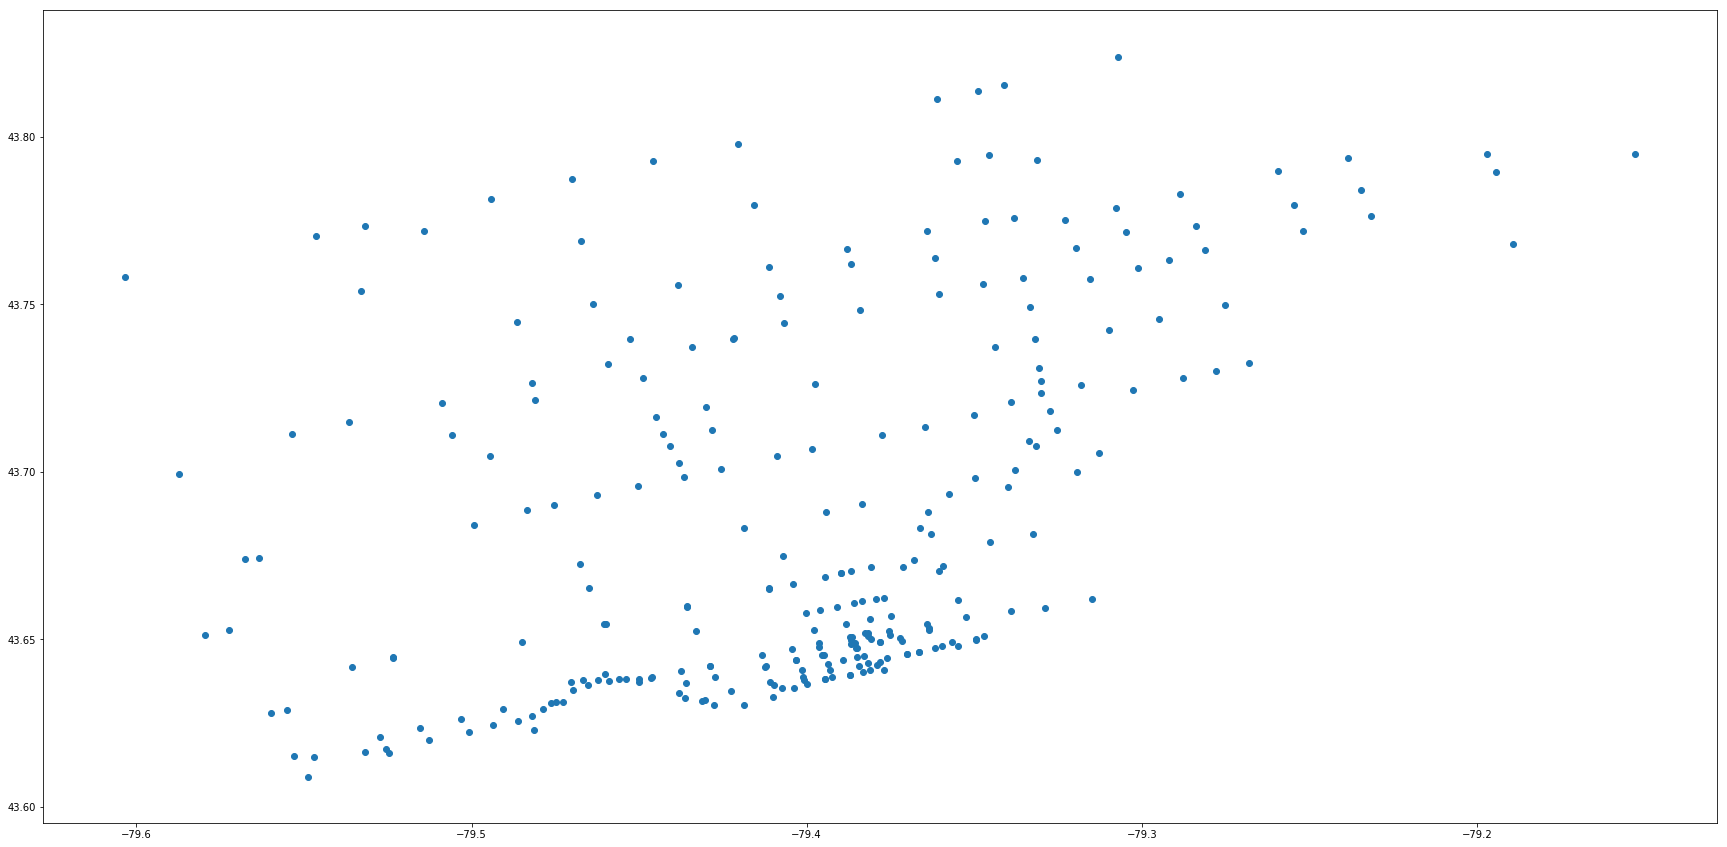

In [11]:
trafficlights.plot(figsize=(30,20))

## Setting the projection


You can use to_crs to convert to different projections. In typical pandas fashion, you can do it a lot of ways, but the easiest is to send a epsg= and feed it the correct EPSG code.

You’ll also probably want to do an ax.axis('off') to turn off the splines and axes!

(-79.62804551023066, -79.1283934897693, 43.59510944169777, 43.83783355830222)

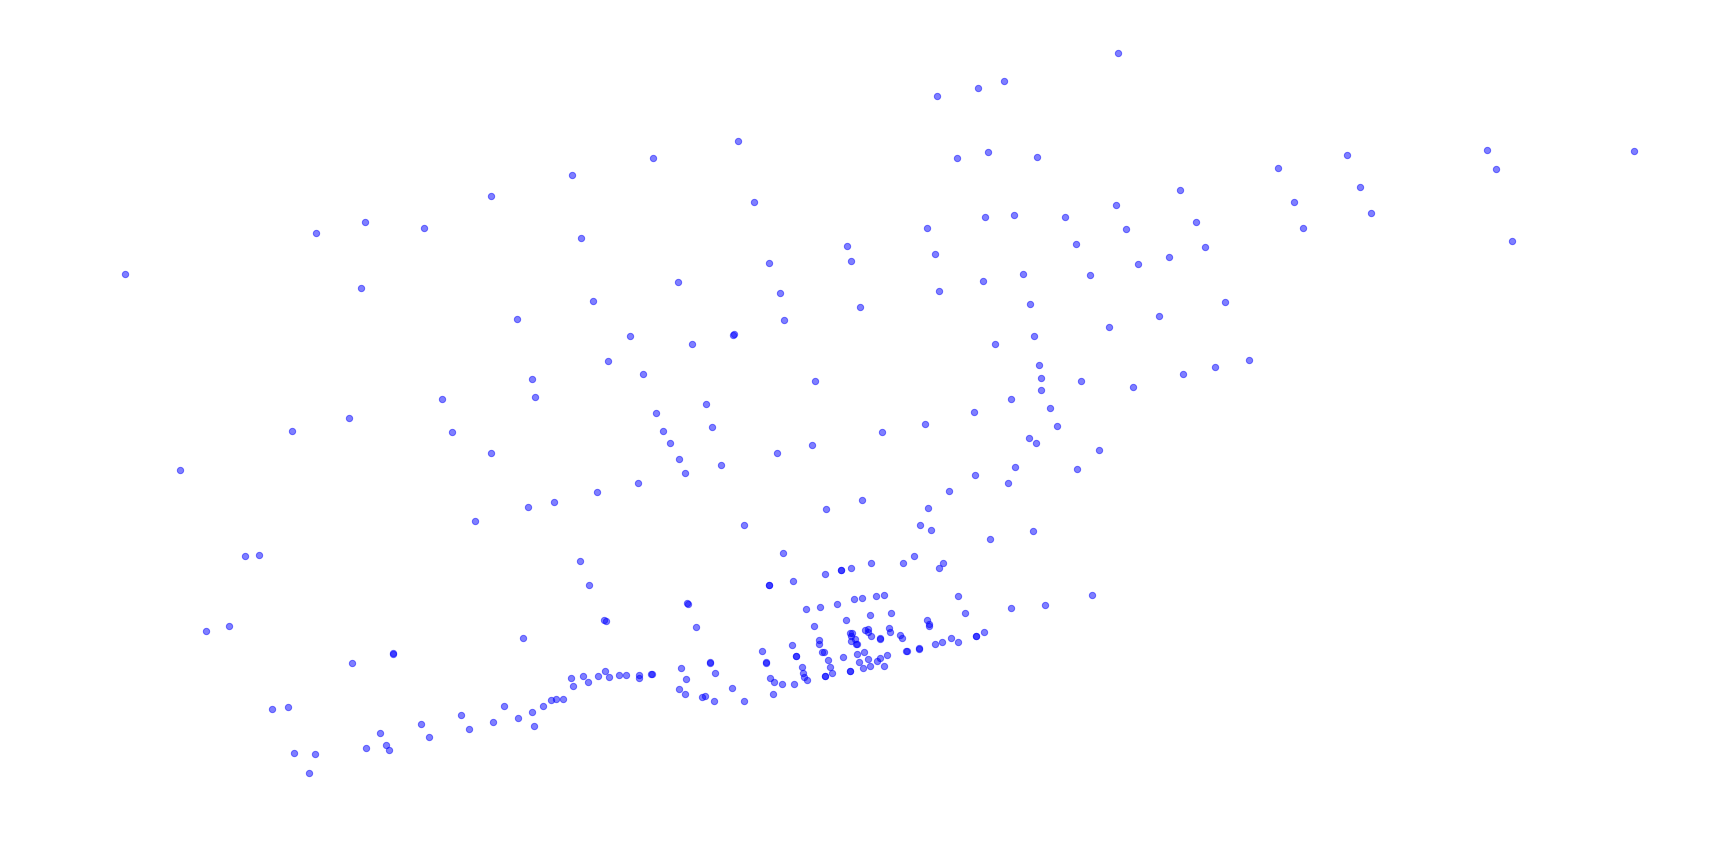

In [12]:
ax = trafficlights.plot(figsize=(30,20), markersize=40, color='blue', alpha=0.5)
ax.axis('off')

In [13]:
#Let`s plot the traffic lights!!!
#Bigger Dots
#Make them transparent

(-79.66546602429999, -79.0890421037, 43.5672729356, 43.8691802424)

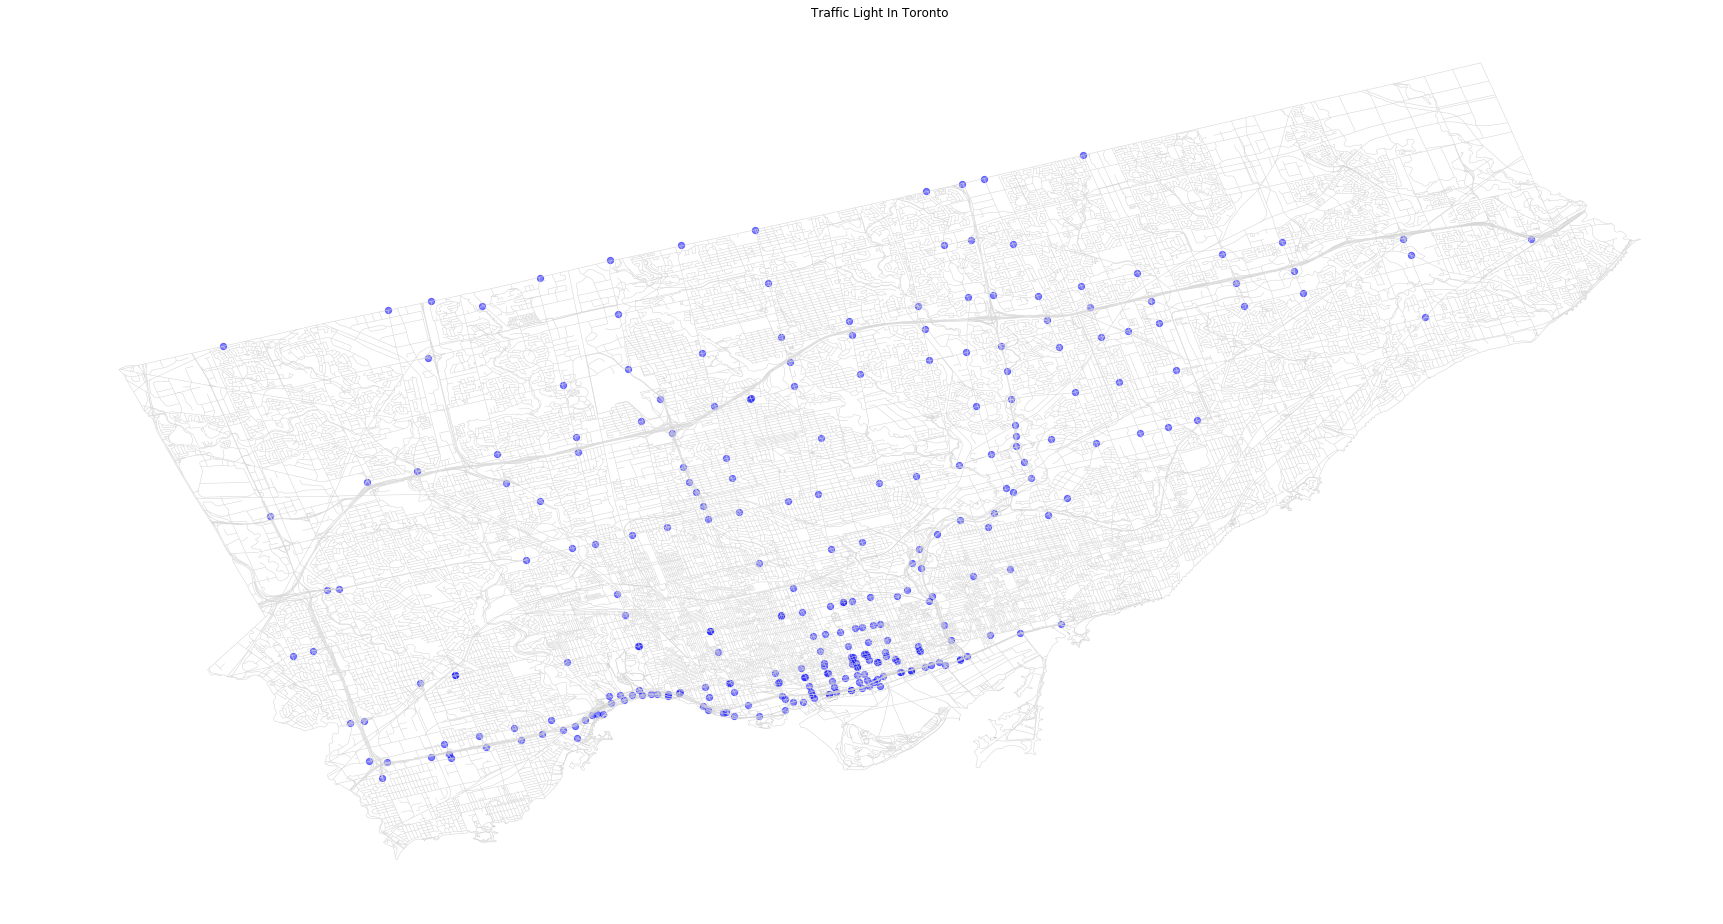

In [14]:
# Save the first layer as ax
ax = toronto.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(30,20))
ax.set_title("Traffic Light In Toronto")
#ax.plot()
# Pass ax=ax to the second layer
trafficlights.plot(figsize=(30,20), ax=ax, markersize=40, color='blue', alpha=0.5)
ax.axis('off')

Here is our map!!! No that bad, but let`s add some more advanced function

# Interactive map


Creating an interactive Bokeh map from Shapefile(s) contains typically following steps:

1.Read the Shapefile into GeoDataFrame
 
2.Calculate the x and y coordinates of the geometries into separate columns

3.Convert the GeoDataFrame into a Bokeh DataSource

4.Plot the x and y coordinates as points, lines or polygons (which are in Bokeh words: circle, multi_line and patches)

We will use the map we just imported, So now let`s calculate the X, Y coordinates.  Unfortunately there is not a ready made function in geopandas to do that.

In [15]:
from bokeh.plotting import figure, save, show, output_file
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.palettes import RdYlBu11 as palette
from bokeh.models import LogColorMapper

First, let`s say what type of geometry shape object do we have

In [16]:
toronto['geometry'].head(1)

0    LINESTRING (-79.54477895300001 43.58582902, -7...
Name: geometry, dtype: object

In [17]:
trafficlights['geometry'].head(1)

0    POINT (-79.381606 43.643023)
Name: geometry, dtype: object

Now, as a second step, we need to calculate the x and y coordinates from the geometry shape Unfortunately there is not a ready made function in geopandas to do that.

Thus, let’s create our own function called getPointCoords() and getLineCoords() which will return the x or y coordinate of a given geometry. It shall have two parameters: geom and coord_type where the first one should be a Shapely geometry object and coord_type should be either 'x' or 'y'.

In [18]:
def getPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

In [19]:
def getLineCoords(row, geom, coord_type):
    """Returns a list of coordinates ('x' or 'y') of a LineString geometry"""
    if coord_type == 'x':
        return list( row[geom].coords.xy[0] )
    elif coord_type == 'y':
        return list( row[geom].coords.xy[1] )

Let`s make a copy of data frame before we modify it

In [20]:
map_copy = toronto.copy()
tl_copy = trafficlights.copy()

In [21]:
# Calculate the coordinates
tl_copy['x'] = trafficlights.apply(getPointCoords, geom='geometry', coord_type='x', axis=1)
tl_copy['y'] = trafficlights.apply(getPointCoords, geom='geometry', coord_type='y', axis=1)

map_copy['x'] = toronto.apply(getLineCoords, geom='geometry', coord_type='x', axis=1)
map_copy['y'] = toronto.apply(getLineCoords, geom='geometry', coord_type='y', axis=1)

Bokeh ColumnDataSource do not understand Shapely geometry -objects. Thus, we need to remove the geometry -column before convert our DataFrame into a ColumnDataSouce.

In [22]:
tl_copy = tl_copy.drop('geometry', axis=1)
map_copy = map_copy.drop('geometry', axis=1)

Now we can convert that pandas DataFrame into a ColumnDataSource.

In [23]:
psource = ColumnDataSource(tl_copy)
msource = ColumnDataSource(map_copy)

Okey, so now we have a ColumnDataSource object that has our data stored in a way that Bokeh wants it.

Finally, we can make a Point map of those points in a fairly similar manner as in the first example. Now instead of passing the coordinate lists, we can pass the data as a source for the plot with column names containing those coordinates.

Let`s add the interative tool to our map

In [24]:
p = figure(title="A map of traffic lights in toronto")

# Plot grid
p.patches('x', 'y', source=msource,
         fill_alpha=1.0, line_color="black", line_width=0.05)

# Add points on top (as black points)
p.circle('x', 'y', size=3, source=psource, color="black")

# show the figure

GlyphRenderer(id='c1e80353-f45a-4e38-a44b-5698517af3b2', ...)

In [25]:
my_hover = HoverTool()
my_hover.tooltips = [('Address of the point', '@address')]
p.add_tools(my_hover)

Let`s see how our map looks like!!

In [26]:
show(p)

Or you can save it in your local machine

In [27]:
outfp = r"trafficlightsToronto_map.html"
output_file('plot.html', mode='inline')
save(obj=p, filename=outfp)

'/Users/IDK/Desktop/2019_bdc_workshops-master/Week_Two_Data_Handling/trafficlightsToronto_map.html'

That`s it, congralations on finishing the workshop for data visulazation!!   I hope this tutorial was helpful and please don't hesitate to ask for help. Feedback that you provide will be taken into consideration for future workshops and I hope that you learned something. Good luck on your projects!